---
title: "NIST (part 2): Traditional ML: Gradient boosting"

date: 2022-10-05
date-modified: last-modified

author:

- name: Ralf Gabriels

  orcid: 0000-0002-1679-1711

  affiliations:
    - VIB-UGent Center for Medical Biotechnology, VIB, Belgium
    - Department of Biomolecular Medicine, Ghent University, Belgium

---

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ProteomicsML/ProteomicsML/blob/main/tutorials/fragmentation/_nist-2-traditional-ml-gradient-boosting.ipynb)

## 1. Introduction

This is the second part in a three-part tutorial. We recommend you to to start with the
first section, where the NIST spectral library is parsed and prepared for use in the
second and third parts.

1. [Preparing a spectral library for ML][part1]
2. [Traditional ML: Gradient boosting][part2]
3. [Deep learning: BiLSTM][part3]

[part1]: https://www.proteomicsml.org/tutorials/fragmentation/nist-1-parsing-spectral-library.html
[part2]: https://www.proteomicsml.org/tutorials/fragmentation/nist-2-traditional-ml-gradient-boosting.html
[part3]: https://www.proteomicsml.org/tutorials/fragmentation/nist-3-deep-learning-lstm.html


In this tutorial, you will learn how to build a fragmentation intensity predictor
similar to MS²PIP v3 [@Gabriels2019] with traditional machine learning (ML) feature
engineering and Gradient Boosting [@Friedman2002].

In [ ]:
# Installing required python packages
! pip install rich numpy pandas pyarrow matplotlib seaborn scikit-learn hyperopt --quiet

## 2 Data preparation

We will use the spectral library that was already parsed in part 1 of this
tutorial series.

In [ ]:
import pandas as pd

train_val_spectra = pd.read_feather("http://ftp.pride.ebi.ac.uk/pub/databases/pride/resources/proteomicsml/fragmentation/nist-humanhcd20160503-parsed-trainval.feather")
test_spectra = pd.read_feather("http://ftp.pride.ebi.ac.uk/pub/databases/pride/resources/proteomicsml/fragmentation/nist-humanhcd20160503-parsed-test.feather")


### 2.1 Feature engineering

In traditional ML, the input features for the algorithm usually require some
engineering. For fragmentation intensity prediction this is not different. Following
the MS²PIP methods, we will calculate the distributions of several amino acid properties
across the peptide and fragment ion sequences.

Using the distribution of these properties instead of the actual properties per amino
acid allows MS²PIP to get a fixed length feature matrix for input peptides with varying
lengths.

In [ ]:
import numpy as np
import pandas as pd
from rich import progress

In [ ]:
amino_acids = list("ACDEFGHIKLMNPQRSTVWY")
properties = np.array([
    [37,35,59,129,94,0,210,81,191,81,106,101,117,115,343,49,90,60,134,104],  # basicity
    [68,23,33,29,70,58,41,73,32,73,66,38,0,40,39,44,53,71,51,55],  # helicity
    [51,75,25,35,100,16,3,94,0,94,82,12,0,22,22,21,39,80,98,70],  # hydrophobicity
    [32,23,0,4,27,32,48,32,69,32,29,26,35,28,79,29,28,31,31,28],  # pI
])

pd.DataFrame(properties, columns=amino_acids, index=["basicity", "helicity", "hydrophobicity", "pI"])

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
basicity,37,35,59,129,94,0,210,81,191,81,106,101,117,115,343,49,90,60,134,104
helicity,68,23,33,29,70,58,41,73,32,73,66,38,0,40,39,44,53,71,51,55
hydrophobicity,51,75,25,35,100,16,3,94,0,94,82,12,0,22,22,21,39,80,98,70
pI,32,23,0,4,27,32,48,32,69,32,29,26,35,28,79,29,28,31,31,28


In [ ]:
def encode_peptide(sequence, charge):
    # 4 properties * 5 quantiles * 3 ion types + 4 properties * 4 site + 2 global
    n_features = 78
    quantiles = [0, 0.25, 0.5, 0.75, 1]
    n_ions = len(sequence) - 1

    # Encode amino acids as integers to index amino acid properties for peptide sequence
    aa_indices = {aa: i for i, aa in  enumerate("ACDEFGHIKLMNPQRSTVWY")}
    aa_to_index = np.vectorize(lambda aa: aa_indices[aa])
    peptide_indexed = aa_to_index(np.array(list(sequence)))
    peptide_properties = properties[:, peptide_indexed]

    # Empty peptide_features array
    peptide_features = np.full((n_ions, n_features), np.nan)

    for b_ion_number in range(1, n_ions + 1):
        # Calculate quantiles of features across peptide, b-ion, and y-ion
        peptide_quantiles = np.hstack(
            np.quantile(peptide_properties, quantiles, axis=1).transpose()
        )
        b_ion_quantiles = np.hstack(
            np.quantile(peptide_properties[:,:b_ion_number], quantiles, axis=1).transpose()
        )
        y_ion_quantiles = np.hstack(
            np.quantile(peptide_properties[:,b_ion_number:], quantiles, axis=1).transpose()
        )

        # Properties on specific sites: nterm, frag-1, frag+1, cterm
        specific_site_indexes = np.array([0, b_ion_number - 1, b_ion_number, -1])
        specific_site_properties = np.hstack(peptide_properties[:, specific_site_indexes].transpose())

        # Global features: Length and charge
        global_features = np.array([len(sequence), int(charge)])

        # Assign to peptide_features array
        peptide_features[b_ion_number - 1, 0:20] = peptide_quantiles
        peptide_features[b_ion_number - 1, 20:40] = b_ion_quantiles
        peptide_features[b_ion_number - 1, 40:60] = y_ion_quantiles
        peptide_features[b_ion_number - 1, 60:76] = specific_site_properties
        peptide_features[b_ion_number - 1, 76:78] = global_features

    return peptide_features


def generate_feature_names():
    feature_names = []
    for level in ["peptide", "b", "y"]:
        for aa_property in ["basicity", "helicity", "hydrophobicity", "pi"]:
            for quantile in ["min", "q1", "q2", "q3", "max"]:
                feature_names.append("_".join([level, aa_property, quantile]))
    for site in ["nterm", "fragmin1", "fragplus1", "cterm"]:
        for aa_property in ["basicity", "helicity", "hydrophobicity", "pi"]:
            feature_names.append("_".join([site, aa_property]))

    feature_names.extend(["length", "charge"])
    return feature_names

Let's test it with a single peptide. Feel free to use your own name as a "peptide"; as
long as it does not contain any non-amino acid characters.

In [ ]:
peptide_features = pd.DataFrame(encode_peptide("RALFGARIELS", 2), columns=generate_feature_names())
peptide_features

,peptide_basicity_min,peptide_basicity_q1,peptide_basicity_q2,peptide_basicity_q3,peptide_basicity_max,peptide_helicity_min,peptide_helicity_q1,peptide_helicity_q2,peptide_helicity_q3,peptide_helicity_max,...,fragplus1_basicity,fragplus1_helicity,fragplus1_hydrophobicity,fragplus1_pi,cterm_basicity,cterm_helicity,cterm_hydrophobicity,cterm_pi,length,charge
0,0.0,43.0,81.0,111.5,343.0,29.0,41.5,68.0,71.5,73.0,...,37.0,68.0,51.0,32.0,49.0,44.0,21.0,29.0,11.0,2.0
1,0.0,43.0,81.0,111.5,343.0,29.0,41.5,68.0,71.5,73.0,...,81.0,73.0,94.0,32.0,49.0,44.0,21.0,29.0,11.0,2.0
2,0.0,43.0,81.0,111.5,343.0,29.0,41.5,68.0,71.5,73.0,...,94.0,70.0,100.0,27.0,49.0,44.0,21.0,29.0,11.0,2.0
3,0.0,43.0,81.0,111.5,343.0,29.0,41.5,68.0,71.5,73.0,...,0.0,58.0,16.0,32.0,49.0,44.0,21.0,29.0,11.0,2.0
4,0.0,43.0,81.0,111.5,343.0,29.0,41.5,68.0,71.5,73.0,...,37.0,68.0,51.0,32.0,49.0,44.0,21.0,29.0,11.0,2.0
5,0.0,43.0,81.0,111.5,343.0,29.0,41.5,68.0,71.5,73.0,...,343.0,39.0,22.0,79.0,49.0,44.0,21.0,29.0,11.0,2.0
6,0.0,43.0,81.0,111.5,343.0,29.0,41.5,68.0,71.5,73.0,...,81.0,73.0,94.0,32.0,49.0,44.0,21.0,29.0,11.0,2.0
7,0.0,43.0,81.0,111.5,343.0,29.0,41.5,68.0,71.5,73.0,...,129.0,29.0,35.0,4.0,49.0,44.0,21.0,29.0,11.0,2.0
8,0.0,43.0,81.0,111.5,343.0,29.0,41.5,68.0,71.5,73.0,...,81.0,73.0,94.0,32.0,49.0,44.0,21.0,29.0,11.0,2.0
9,0.0,43.0,81.0,111.5,343.0,29.0,41.5,68.0,71.5,73.0,...,49.0,44.0,21.0,29.0,49.0,44.0,21.0,29.0,11.0,2.0


### 2.2 Getting the target intensities

The target intensities are the observed intensities which the model will learn to
predict. Let's first try with a single spectrum.

In [ ]:
test_spectrum = train_val_spectra.iloc[4]

peptide_targets =  pd.DataFrame({
    "b_target": test_spectrum["parsed_intensity"]["b"],
    "y_target": test_spectrum["parsed_intensity"]["y"],
})
peptide_targets

,b_target,y_target
0,0.000000,0.118507
1,0.229717,0.079770
2,0.294631,0.088712
3,0.234662,0.145900
4,0.185732,0.205005
5,0.134395,0.261630
6,0.081856,0.305119
7,0.043793,0.296351
8,0.000000,0.205703
9,0.000000,0.155991


These are the intensities for the b- and y-ions, each ordered from 1 to 9. 
In MS²PIP, however, a clever trick is applied to reuse the computed features for each
*fragment ion pair*. Doing so makes perfect sense, as both ions in such a fragment ion
pair originated from the same fragmentation event. For this peptide, the fragment ion
pairs are b1-y9, b2-y8, b3-y7, etc. To match all of the pairs, we simply have to reverse
the y-ion series intensities:

In [ ]:
peptide_targets =  pd.DataFrame({
    "b_target": test_spectrum["parsed_intensity"]["b"],
    "y_target": test_spectrum["parsed_intensity"]["y"][::-1],
})
peptide_targets

,b_target,y_target
0,0.000000,0.000000
1,0.229717,0.155991
2,0.294631,0.205703
3,0.234662,0.296351
4,0.185732,0.305119
5,0.134395,0.261630
6,0.081856,0.205005
7,0.043793,0.145900
8,0.000000,0.088712
9,0.000000,0.079770


### 2.3 Bringing it all together

In [ ]:
features = encode_peptide(test_spectrum["sequence"], test_spectrum["charge"])
targets = np.stack([test_spectrum["parsed_intensity"]["b"], test_spectrum["parsed_intensity"]["y"][::-1]], axis=1)
spectrum_id = np.full(shape=(targets.shape[0], 1), fill_value=test_spectrum["index"])  # Repeat id for all ions

In [ ]:
pd.DataFrame(np.hstack([spectrum_id, features, targets]), columns=["spectrum_id"] + generate_feature_names() + ["b_target",  "y_target"])

,spectrum_id,peptide_basicity_min,peptide_basicity_q1,peptide_basicity_q2,peptide_basicity_q3,peptide_basicity_max,peptide_helicity_min,peptide_helicity_q1,peptide_helicity_q2,peptide_helicity_q3,...,fragplus1_hydrophobicity,fragplus1_pi,cterm_basicity,cterm_helicity,cterm_hydrophobicity,cterm_pi,length,charge,b_target,y_target
0,5.0,37.0,37.0,37.0,40.0,343.0,39.0,68.0,68.0,68.0,...,51.0,32.0,343.0,39.0,22.0,79.0,12.0,2.0,0.000000,0.000000
1,5.0,37.0,37.0,37.0,40.0,343.0,39.0,68.0,68.0,68.0,...,51.0,32.0,343.0,39.0,22.0,79.0,12.0,2.0,0.229717,0.155991
2,5.0,37.0,37.0,37.0,40.0,343.0,39.0,68.0,68.0,68.0,...,51.0,32.0,343.0,39.0,22.0,79.0,12.0,2.0,0.294631,0.205703
3,5.0,37.0,37.0,37.0,40.0,343.0,39.0,68.0,68.0,68.0,...,51.0,32.0,343.0,39.0,22.0,79.0,12.0,2.0,0.234662,0.296351
4,5.0,37.0,37.0,37.0,40.0,343.0,39.0,68.0,68.0,68.0,...,51.0,32.0,343.0,39.0,22.0,79.0,12.0,2.0,0.185732,0.305119
5,5.0,37.0,37.0,37.0,40.0,343.0,39.0,68.0,68.0,68.0,...,51.0,32.0,343.0,39.0,22.0,79.0,12.0,2.0,0.134395,0.261630
6,5.0,37.0,37.0,37.0,40.0,343.0,39.0,68.0,68.0,68.0,...,51.0,32.0,343.0,39.0,22.0,79.0,12.0,2.0,0.081856,0.205005
7,5.0,37.0,37.0,37.0,40.0,343.0,39.0,68.0,68.0,68.0,...,51.0,32.0,343.0,39.0,22.0,79.0,12.0,2.0,0.043793,0.145900
8,5.0,37.0,37.0,37.0,40.0,343.0,39.0,68.0,68.0,68.0,...,80.0,31.0,343.0,39.0,22.0,79.0,12.0,2.0,0.000000,0.088712
9,5.0,37.0,37.0,37.0,40.0,343.0,39.0,68.0,68.0,68.0,...,21.0,29.0,343.0,39.0,22.0,79.0,12.0,2.0,0.000000,0.079770


The following function applies these steps over a collection of spectra and returns
the full feature/target table:

In [ ]:
def generate_ml_input(spectra):
    tables = []
    for spectrum in progress.track(spectra.to_dict(orient="records")):
        features = encode_peptide(spectrum["sequence"], spectrum["charge"])
        targets = np.stack([spectrum["parsed_intensity"]["b"], spectrum["parsed_intensity"]["y"][::-1]], axis=1)
        spectrum_id = np.full(shape=(targets.shape[0], 1), fill_value=spectrum["index"])  # Repeat id for all ions
        table = np.hstack([spectrum_id, features, targets])
        tables.append(table)

    full_table = np.vstack(tables)
    spectra_encoded = pd.DataFrame(full_table, columns=["spectrum_id"] + generate_feature_names() + ["b_target",  "y_target"])
    return spectra_encoded

Note that this might take some time, sometimes up to 30 minutes. To skip this step,
simple download the file with pre-encoded features and targets, and load in two cells
below.

In [ ]:
train_val_encoded = generate_ml_input(train_val_spectra)
train_val_encoded.to_feather("fragmentation-nist-humanhcd20160503-parsed-trainval-encoded.feather")

test_encoded = generate_ml_input(test_spectra)
test_encoded.to_feather("fragmentation-nist-humanhcd20160503-parsed-test-encoded.feather")

In [ ]:
# Uncomment this step to load pre-encoded features from a file:

# train_val_encoded = pd.read_feather("http://ftp.pride.ebi.ac.uk/pub/databases/pride/resources/proteomicsml/fragmentation/nist-humanhcd20160503-parsed-trainval-encoded.feather")
# test_encoded = pd.read_feather("http://ftp.pride.ebi.ac.uk/pub/databases/pride/resources/proteomicsml/fragmentation/nist-humanhcd20160503-parsed-test-encoded.feather")

In [ ]:
train_val_encoded

,spectrum_id,peptide_basicity_min,peptide_basicity_q1,peptide_basicity_q2,peptide_basicity_q3,peptide_basicity_max,peptide_helicity_min,peptide_helicity_q1,peptide_helicity_q2,peptide_helicity_q3,...,fragplus1_hydrophobicity,fragplus1_pi,cterm_basicity,cterm_helicity,cterm_hydrophobicity,cterm_pi,length,charge,b_target,y_target
0,0.0,0.0,37.0,37.0,37.0,191.0,32.0,68.0,68.0,68.0,...,51.0,32.0,191.0,32.0,0.0,69.0,22.0,2.0,0.000000,0.000000
1,0.0,0.0,37.0,37.0,37.0,191.0,32.0,68.0,68.0,68.0,...,51.0,32.0,191.0,32.0,0.0,69.0,22.0,2.0,0.094060,0.000000
2,0.0,0.0,37.0,37.0,37.0,191.0,32.0,68.0,68.0,68.0,...,51.0,32.0,191.0,32.0,0.0,69.0,22.0,2.0,0.180642,0.000000
3,0.0,0.0,37.0,37.0,37.0,191.0,32.0,68.0,68.0,68.0,...,51.0,32.0,191.0,32.0,0.0,69.0,22.0,2.0,0.204203,0.050476
4,0.0,0.0,37.0,37.0,37.0,191.0,32.0,68.0,68.0,68.0,...,51.0,32.0,191.0,32.0,0.0,69.0,22.0,2.0,0.233472,0.094835
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3321136,398372.0,81.0,104.0,104.0,153.0,343.0,39.0,48.5,55.0,55.0,...,70.0,28.0,343.0,39.0,22.0,79.0,8.0,3.0,0.000000,0.180938
3321137,398372.0,81.0,104.0,104.0,153.0,343.0,39.0,48.5,55.0,55.0,...,98.0,31.0,343.0,39.0,22.0,79.0,8.0,3.0,0.000000,0.203977
3321138,398372.0,81.0,104.0,104.0,153.0,343.0,39.0,48.5,55.0,55.0,...,3.0,48.0,343.0,39.0,22.0,79.0,8.0,3.0,0.000000,0.169803
3321139,398372.0,81.0,104.0,104.0,153.0,343.0,39.0,48.5,55.0,55.0,...,94.0,32.0,343.0,39.0,22.0,79.0,8.0,3.0,0.000000,0.120565


This is the data we will use for training. Note that each spectrum comprises of
multiple lines: One line per b/y-ion couple.

## 3 Training the model

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

Let's first try to train a simple model on the train set and evaluate its performance on the test
set. 

In [ ]:
reg =  GradientBoostingRegressor()

X_train = train_val_encoded.drop(columns=["spectrum_id", "b_target",  "y_target"])
y_train = train_val_encoded["y_target"]
X_test = test_encoded.drop(columns=["spectrum_id", "b_target",  "y_target"])
y_test = test_encoded["y_target"]

# For demo purposes, we only use the first 100k samples
reg.fit(X_train.head(100000), y_train.head(100000))

# Uncomment this step to train the model on the full dataset:
# reg.fit(X_train, y_train)

GradientBoostingRegressor()

In [ ]:
y_test_pred = reg.predict(X_test)
np.corrcoef(y_test, y_test_pred)[0][1]

0.7091798896983967

Not terrible. Let's see if we can do better after hyperparameters optimization. For
this, we can use the hyperopt package.

In [ ]:
from hyperopt import fmin, hp, tpe, STATUS_OK

In [ ]:
def objective(n_estimators):
    # Define algorithm
    reg =  GradientBoostingRegressor(n_estimators=n_estimators)

    # Fit model
    # For demo purposes, we only use the first 100k samples
    reg.fit(X_train.head(100000), y_train.head(100000))

    # Uncomment this step to train the model on the full dataset:
    # reg.fit(X_train, y_train)

    # Test model
    y_test_pred = reg.predict(X_test)
    correlation = np.corrcoef(y_test, y_test_pred)[0][1]

    return {'loss': -correlation, 'status': STATUS_OK}

In [ ]:
best_params = fmin(
  fn=objective,
  space=10 + hp.randint('n_estimators', 980),
  algo=tpe.suggest,
  max_evals=10,
)

100%|██████████| 10/10 [37:15<00:00, 223.58s/trial, best loss: -0.75991576993057] 


In [ ]:
best_params

{'n_estimators': 966}

Initially, the default value of 100 estimators was used. According to
this hyperopt run, using 966 estimators results in a more performant model.

Now we can train the model again with this new hyperparameter value:

In [ ]:
reg =  GradientBoostingRegressor(n_estimators=best_params["n_estimators"])

X_train = train_val_encoded.drop(columns=["spectrum_id", "b_target",  "y_target"])
y_train = train_val_encoded["y_target"]
X_test = test_encoded.drop(columns=["spectrum_id", "b_target",  "y_target"])
y_test = test_encoded["y_target"]

reg.fit(X_train.head(100000), y_train.head(100000))

GradientBoostingRegressor(n_estimators=966)

In [ ]:
y_test_pred = reg.predict(X_test)
np.corrcoef(y_test, y_test_pred)[0][1]

0.7593069387129985

Much better already. To get a more accurate view of the model performance, we should
calculate the correlation per spectrum, instead of across the full dataset:

In [ ]:
prediction_df_y = pd.DataFrame({
    "spectrum_id": test_encoded["spectrum_id"],
    "target_y": y_test,
    "prediction_y": y_test_pred,
})
prediction_df_y

,spectrum_id,target_y,prediction_y
0,9.0,0.000000,0.006154
1,9.0,0.000000,0.008823
2,9.0,0.000000,0.010059
3,9.0,0.000000,0.011024
4,9.0,0.000000,0.019898
...,...,...,...
367683,398369.0,0.000000,0.262313
367684,398369.0,0.224074,0.268292
367685,398369.0,0.283664,0.208505
367686,398369.0,0.185094,0.177186


In [ ]:
corr_y = prediction_df_y.groupby("spectrum_id").corr().iloc[::2]['prediction_y']
corr_y.index = corr_y.index.droplevel(1)
corr_y = corr_y.reset_index().rename(columns={"prediction_y": "correlation"})
corr_y

,spectrum_id,correlation
0,9.0,0.868330
1,16.0,0.725240
2,39.0,0.101923
3,95.0,0.118734
4,140.0,0.785892
...,...,...
27031,398328.0,0.675631
27032,398341.0,0.066689
27033,398342.0,0.763430
27034,398368.0,0.684804


Median correlation:

In [ ]:
corr_y["correlation"].median()

0.7524246447174651

Correlation distribution:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

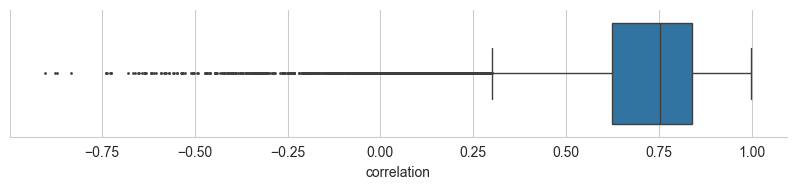

In [ ]:
sns.catplot(
    data=corr_y, x="correlation",
    fliersize=1,
    kind="box", aspect=4, height=2
)
plt.show()

Not bad! With some more hyperparameter optimization (optimizing only the number of trees
is a bit crude) a lot more performance gains could be made. Take a look at the 
[Scikit Learn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)
to learn more about the various hyperparameters for the `GradientBoostingRegressor`.
Alternatively, you could switch to the
[XGBoost algorithm](https://xgboost.readthedocs.io/en/stable/), which is currently used
by MS²PIP.

And of course, this model can only predict y-ion intensities. You can repeat the
training and optimization steps to train a model for b-ion intensities.

Good luck!